In [2]:
#라이브러리

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


In [ ]:
# 1. μ-law Companding (데이터 전처리 함수)
def mu_law_encode(audio, quantization_channels=256):
    """
    오디오 신호를 양자화
    -> -1과 1 사이의 연속적인 값을 0에서 255 사이의 정수로 변환

    Args:
        audio (Tensor or ndarray): 오디오 신호
        quantization_channels (int): 양자화 채널 수

    Returns:
        Tensor: 양자화된 오디오 신호
    """

    #공식에 사용할 mu(상수) 정의
    mu = torch.tensor(quantization_channels - 1, dtype=torch.float32)
    if not isinstance(audio, torch.Tensor): #입력이 numpy인 경우 pytorch 텐서로 변환
        audio = torch.tensor(audio, dtype=torch.float32) #0 ~ 255 범위의 정수로 매핑

    #mu-law 공식 적용
    encoded = torch.sign(audio) * torch.log1p(mu * torch.abs(audio)) / torch.log1p(mu)
    return torch.floor((encoded + 1) / 2 * mu + 0.5).long()

def mu_law_decode(output, quantization_channels=256):
    """
    다시 오디오 신호로 복원하는 함수
    0~255 의 정수 값을 -1과 1 사이의 연속적인 값으로 변환

    Args:
        output (Tensor or ndarray): 0 ~ 255 정수 값을 갖는 데이터
        quantization_channels (int): 양자화 채널 수

    Returns:
        Tensor: 복원된 오디오 신호
    """

    mu = torch.tensor(quantization_channels - 1, dtype=torch.float32)
    if not isinstance(output, torch.Tensor):
        output = torch.tensor(output, dtype=torch.float32)
    #정수 값 범위를 -1과 1 사이로
    x = (output / mu) * 2. - 1.

    #mu-law 확장 공식 적용
    decoded = torch.sign(x) * (torch.exp(torch.abs(x) * torch.log1p(mu)) - 1.) / mu
    return decoded


In [3]:
# 2. Causal Convolution
#t 시점의 출력을 예측할 때 t 시점 및 그 이전의 입력만 보도록 보장
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super(CausalConv1d, self).__init__()

        #입력 데이터의 왼쪽(과거 방향)에만 패딩을 추가
        # -> 필터가 현재 시점을 계산할 때 미래 시점의 실제 데이터를 볼 수 없게 함
        self.padding = (kernel_size - 1) * dilation #왼쪽(과거 방향)에만 패딩
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        ###############################오류 해결
        # self.padding이 0일 때 [:, :, :-0] 슬라이싱이 빈 텐서를 반환하는 문제를 해결
        if self.padding > 0:
            return x[:, :, :-self.padding] # 양쪽에 추가된 패딩 중, 미래 정보에 해당하는 오른쪽 패딩 부분을 잘라냄
        else:
            return x


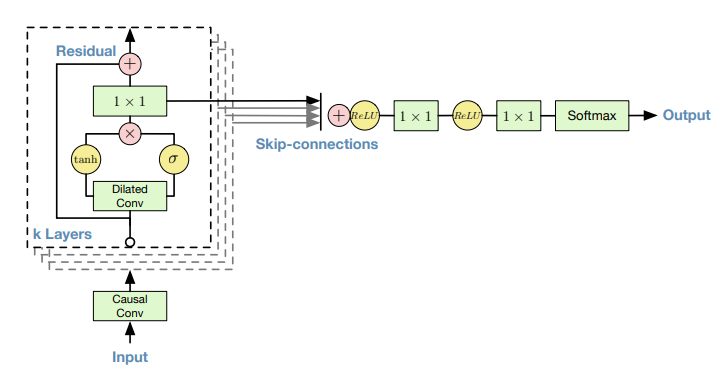

In [4]:
# 3. Residual Block
# Gated Activation Unit, Dilated Causal Convolution, Residual/Skip Connection을 포함
class ResidualBlock(nn.Module):
    def __init__(self, residual_channels, skip_channels, kernel_size, dilation):
        super(ResidualBlock, self).__init__()

        #Dilated Causal Convolution. 출력 채널을 두 배로 하여 filter와 gate로 사용
        self.dilated_conv = CausalConv1d(residual_channels, 2 * residual_channels,
                                         kernel_size=kernel_size, dilation=dilation)

        # 1x1 컨볼루션을 사용하여 채널 수를 맞춤
        self.res_conv = nn.Conv1d(residual_channels, residual_channels, kernel_size=1)
        self.skip_conv = nn.Conv1d(residual_channels, skip_channels, kernel_size=1)

    def forward(self, x):
        residual = x
        dilated_out = self.dilated_conv(x) #Dilated Causal Convolution 적용
        in_channels = dilated_out.size(1) // 2 #출력을 filter와 gate로 분리
        tanh_out = torch.tanh(dilated_out[:, :in_channels, :])
        sigmoid_out = torch.sigmoid(dilated_out[:, in_channels:, :])
        gated_activation = tanh_out * sigmoid_out

        res = self.res_conv(gated_activation)
        output = res + residual # Residual Connection: 입력과 1x1 conv 결과를 더함
        skip = self.skip_conv(gated_activation)
        return output, skip


In [5]:
# 4. WaveNet 모델
class WaveNet(nn.Module):
    def __init__(self, num_classes=256,
                 num_blocks=3,
                 num_layers=10,
                 residual_channels=32,
                 skip_channels=64,
                 kernel_size=2):
        super(WaveNet, self).__init__()
        self.num_classes = num_classes
        self.num_blocks = num_blocks
        self.num_layers = num_layers
        self.residual_channels = residual_channels
        self.skip_channels = skip_channels
        self.kernel_size = kernel_size

        self.start_conv = CausalConv1d(num_classes, residual_channels, kernel_size=1) #Start Convolution

        #Residual Block
        self.residual_blocks = nn.ModuleList()
        # 지정된 스택과 레이어 수만큼 블록을 쌓음
        for b in range(num_blocks):
            for i in range(num_layers):
                dilation = 2 ** i #dilation 값은 2의 거듭제곱으로 증가
                self.residual_blocks.append(
                    ResidualBlock(residual_channels, skip_channels, kernel_size, dilation)
                )

        #End Convolution
        #모든 skip connection을 합쳐 최종 출력 생성
        self.end_conv_1 = nn.Conv1d(skip_channels, skip_channels, kernel_size=1)
        self.end_conv_2 = nn.Conv1d(skip_channels, num_classes, kernel_size=1)

    def forward(self, x):
        #정수 레이블을 one-hot 벡터로 변환
        x = F.one_hot(x, self.num_classes).float()
        x = x.transpose(1, 2) #(Batch, Channels, Timesteps)

        #Start Convolution
        x = self.start_conv(x)

        skip_connections = []
        #Residual Block을 순차적으로 통과
        for block in self.residual_blocks:
            x, skip = block(x)
            skip_connections.append(skip)

        #모든 skip connection 합산
        total_skip = sum(skip_connections)

        #End Convolution
        out = F.relu(total_skip)
        out = self.end_conv_1(out)
        out = F.relu(out)
        out = self.end_conv_2(out)
        return out

    def generate(self, initial_sample, length):

        """
        autoregressive 방식으로 새로운 오디오 생성
        """

        self.eval() #평가 모드
        #초기 샘플을 입력 형식에 맞게 준비
        generated_samples = [initial_sample]
        current_input = torch.tensor([initial_sample]).long().unsqueeze(0) # 모델에 입력될 현재 시퀀스

        with torch.no_grad():
            for i in range(length - 1):
                if (i + 1) % 100 == 0:
                    print(f"Generating sample {i+1}/{length-1}...")
                logits = self.forward(current_input)

                #마지막 타임스텝의 logits만 사용
                last_logits = logits[:, :, -1]
                probs = F.softmax(last_logits, dim=1)
                next_sample = torch.multinomial(probs, num_samples=1).squeeze().item()

                #생성된 샘플을 리스트에 추가 -> 다음 입력으로 사용
                generated_samples.append(next_sample)
                current_input = torch.tensor(generated_samples).long().unsqueeze(0)

        self.train() #학습 모드
        return generated_samples

    def calculate_receptive_field(self):
        """모델의 수용 영역(Receptive Field)을 계산"""
        # 수용 영역: 하나의 출력을 계산하기 위해 모델이 봐야 하는 과거 입력 샘플의 총 수

        sum_dilations = sum([2**i for i in range(self.num_layers)])
        return 1 + (self.kernel_size - 1) * self.num_blocks * sum_dilations


In [8]:
# --- 5. 학습 및 생성 예제 ---
if __name__ == '__main__':
    model = WaveNet(
        num_classes=256,
        num_blocks=2,
        num_layers=8,
        residual_channels=16,
        skip_channels=32,
        kernel_size=2
    )
    print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

    receptive_field = model.calculate_receptive_field()
    print(f"모델의 수용 영역(Receptive Field): {receptive_field} 샘플")

    # 간단한 샘플 데이터 생성
    sample_rate = 4000
    duration = 5.0
    freq = 440.0
    t = np.linspace(0., duration, int(sample_rate * duration), endpoint=False)
    dummy_audio = 0.5 * np.sin(2. * np.pi * freq * t)

    # 데이터 전처리
    quantized_audio = mu_law_encode(dummy_audio)
    x_train = quantized_audio[:-1].unsqueeze(0)
    y_target = quantized_audio[1:].unsqueeze(0)

    # 옵티마이저, 손실 함수
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # 학습 루프
    print("학습 시작")
    epochs = 200
    for epoch in range(epochs):
        optimizer.zero_grad()

        # 모델 예측
        output = model(x_train) # output: (Batch, Classes, Timesteps)

        # 손실 계산
        # CrossEntropyLoss는 (N, C)와 (N) 형태의 입력을 기대하므로 차원 변경
        loss = criterion(output, y_target)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    print("학습 종료")

    # 오디오 생성
    print("오디오 생성 시작")
    initial_sample = 128 # 중간 값에서 시작
    generated_sequence = model.generate(initial_sample, length=sample_rate)

    # 생성된 시퀀스를 오디오 파형으로 디코딩
    generated_audio = mu_law_decode(torch.tensor(generated_sequence))

    print(f"생성된 오디오 길이: {len(generated_audio)} 샘플")


모델 파라미터 수: 43,568
모델의 수용 영역(Receptive Field): 511 샘플
학습 시작
Epoch [20/200], Loss: 5.1038
Epoch [40/200], Loss: 4.1376
Epoch [60/200], Loss: 3.6527
Epoch [80/200], Loss: 3.4381
Epoch [100/200], Loss: 2.7226
Epoch [120/200], Loss: 1.8373
Epoch [140/200], Loss: 0.9849
Epoch [160/200], Loss: 0.3295
Epoch [180/200], Loss: 0.0862
Epoch [200/200], Loss: 0.0323
학습 종료
오디오 생성 시작
Generating sample 100/3999...
Generating sample 200/3999...
Generating sample 300/3999...
Generating sample 400/3999...
Generating sample 500/3999...
Generating sample 600/3999...
Generating sample 700/3999...
Generating sample 800/3999...
Generating sample 900/3999...
Generating sample 1000/3999...
Generating sample 1100/3999...
Generating sample 1200/3999...
Generating sample 1300/3999...
Generating sample 1400/3999...
Generating sample 1500/3999...
Generating sample 1600/3999...
Generating sample 1700/3999...
Generating sample 1800/3999...
Generating sample 1900/3999...
Generating sample 2000/3999...
Generating sample 